In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import h5py
import pandas as pd

import strawb
import strawb.sensors.camera as camera
from os.path import join
import matplotlib.pyplot as plt

## Download the files from the ONC server

# Load a single File

In [3]:
# where data is located on the LRZ VM
basepath = "/dss/strawb/raw_module_data/tumpmtspectrometer001/2021_09/"
file_name = join(basepath, 'TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5')


cam_run = camera.FileHandler(file_name)
picture_handler = camera.Images(cam_run)

### alternatively: use the database to find a valid file

In [4]:
# load DB
db = strawb.SyncDBHandler(file_name='Default')  # loads the db

### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR
print(db.dataframe.measurement_type.unique())

### these are the parts of each module that produce data
print(db.dataframe.dataProductCode.unique())

mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module
mask &= db.dataframe.measurement_type.isnull()
# only synced data
mask &= db.dataframe.synced

## select 1h frame around the biolumi event
timestamp = np.datetime64('2021-09-04T23:44:09')
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(1, "h")

['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
[nan 'counts' 'rate_scan' 'basic' 'laser_adjustment']
['LF' 'PMTSD' 'SMRD' 'MSRD' 'PMTTC' 'LIDARSD' 'LIDARRD' 'LIDARTF' 'MTSD'
 'MSCR' 'MSCRCC' 'MSID' 'MTRD' None 'LIDARTOT' 'PMTRD' 'MSSCD' 'MSSD'
 'MTTOT' 'PMTTOT']


In [5]:
### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask]

,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,write_period,write_period_jitter,measurement_type,measurement_duration,laser_position_x0,laser_position_y0,measurement_steps,write_error,measurement_step_width,measurement_subtype
fullPath,,,,,,,,,,,,,,,,,,,,,
/dss/strawb/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_04,2021-09-05 01:51:24.463000+00:00,None,MSSCD,2021-09-04 23:00:00+00:00,2021-09-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,58043955.0,TUMPMTSPECTROMETER001_20210904T230000.000Z-SDA...,2021-09-05 01:51:26.475000+00:00,...,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
### select only the filename
file_name = db.dataframe.fullPath[mask].iloc[-1]
print(file_name)
cam_run = camera.FileHandler(file_name)
picture_handler = camera.Images(cam_run)

/dss/strawb/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210904T230000.000Z-SDAQ-CAMERA.hdf5


In [7]:
# print some parameters
print(f'Module: {cam_run.module}')
print(f'Number of Frames: {cam_run.exposure_time.shape[0]}')
print(f'Date: {np.min(cam_run.time.asdatetime()[:])} - {np.max(cam_run.time.asdatetime()[:])}')
print(f'Exposure Times [s]: {np.unique(cam_run.exposure_time)}')

Module: PMTSPECTROMETER001
Number of Frames: 36
Date: 2021-09-04T22:59:18.344365 - 2021-09-04T23:57:27.277572
Exposure Times [s]: [52.5]


In [8]:
# mask over a threshold + mask invalid frames + mask no lucifer enabled
mask = (picture_handler.integrated_minus_dark > 1e6) & picture_handler.invalid_mask

index = np.argsort(picture_handler.integrated_minus_dark)  # sort by charge [min,...,max]
index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
index = index[::-1]  # revers the order
print(index)

[27]


In [9]:
picture_handler.image2png(
    index=index, 
    directory="./figures",
    f_name_formatter='{i}_{datetime}.png')  # save the images

['/home/di46lez/strawb_examples_no_git/figures/0_2021_09_04_23_44_09.png']

In [10]:
# The raw pixel values are NOT loaded by default to the module to save RAM.
# They can be accessed directly from the file with the index, index = None (default) to loads all images
a = cam_run.raw.getunsorted([1,3,1])
print(a)

# The raw pixel values are NOT loaded by default to the module to save RAM.
# They can be accessed directly from the file with the index, index = None (default) to loads all images
a = cam_run.raw.getunsorted(index=np.arange(len(cam_run.raw)))
print(a[0]) # returns array on default, even if only one element is accessed
print(a[0].shape) # 2D shape of picture

[[[    0     0  8944 ... 26704 12464 20944]
  [ 6704     0     0 ... 25744  7824 16464]
  [    0  2704     0 ... 18384 15024 14384]
  ...
  [63984 60944 65504 ... 65504 65504 65504]
  [65504 64304 65504 ... 65504 65504 65504]
  [65504 65504 65504 ... 65504 65504 65504]]

 [[    0   416 18336 ... 21696 20576 10656]
  [    0     0  5696 ... 15616  9376 29376]
  [ 2496     0  5856 ... 27616 30816 25696]
  ...
  [65504 65504 65376 ... 65504 65504 65504]
  [65504 57216 65504 ... 65504 65504 65504]
  [65504 65504 64256 ... 65504 65504 65504]]

 [[    0     0  8944 ... 26704 12464 20944]
  [ 6704     0     0 ... 25744  7824 16464]
  [    0  2704     0 ... 18384 15024 14384]
  ...
  [63984 60944 65504 ... 65504 65504 65504]
  [65504 64304 65504 ... 65504 65504 65504]
  [65504 65504 65504 ... 65504 65504 65504]]]
[[    0     0  6128 ... 19248 28208 17968]
 [    0     0     0 ... 22448 14768 22288]
 [ 2128     0    48 ... 23568 28048 21648]
 ...
 [65504 65504 65504 ... 65504 65504 65504]
 [65504

### Store the images with Lucifer enabled

In [11]:
import glob
from tqdm import tqdm

In [12]:
search_str = f'{strawb.Config.raw_data_dir}/tumpmtspectrometer002/2021_06/TUMPMTSPECTROMETER002*20210601*-SDAQ-CAMERA.hdf5'
bar = tqdm(glob.glob(search_str), file=sys.stdout, unit='file')

  0%|          | 0/25 [00:00<?, ?file/s]

In [13]:
### loop over a couple of files
for filename in bar:
    bar.set_postfix({'file': filename})
    try:
        cam_run = camera.FileHandler(filename)
        picture_handler = camera.Images(cam_run)
    except Exception as err:
        print('error', filename, err)
        continue

    ### Store the 'brightest' images
    mode_list, mask_list = picture_handler.get_lucifer_mask()  # returns a mask for each lucifer setting
    mask_lucifer = np.any(mask_list, axis=0)  # compress the masks to one mask

    # mask over a threshold + mask invalid frames + mask lucifer (=LED) enabled
    mask = (picture_handler.integrated_minus_dark > 1e6) & picture_handler.invalid_mask & mask_lucifer
    if np.any(mask):
        print("found some!")
        index = np.argsort(picture_handler.integrated_minus_dark)  # sort by charge [min,...,max]
        index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
        index = index[::-1]  # revers the order
        print(index)

        ## save just the first two pictures
        picture_handler.image2png(
            index=index[:2],
            directory="./figures/",
            f_name_formatter='lucifer_{i}_{datetime}.png'
        )  # save the images
        break

  0%|          | 0/25 [00:00<?, ?file/s, file=/dss/strawb/raw_module_data/tumpmtspectrometer002/2021_06/TUMPMTSPECTROMETER002_20210601T060000.000Z-SDAQ-CAMERA.hdf5]found some!
[6 7 9]
  0%|          | 0/25 [00:06<?, ?file/s, file=/dss/strawb/raw_module_data/tumpmtspectrometer002/2021_06/TUMPMTSPECTROMETER002_20210601T060000.000Z-SDAQ-CAMERA.hdf5]


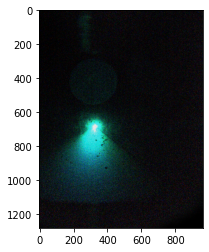

In [14]:
### show one image here
plt.figure()
plt.imshow(picture_handler._rgb[0,:,:]/255)
plt.show()